                                                    Проект №2 
                                        Подготовили Верешко Анна и Леваков Павел
                 Тема исследования: "Будет ли задержка в выплатах в зависимости от характеристик заемщика"

Часть 1. Загрузка необходимых пакетов и обработка датасета

In [1]:
# Загружаем и подключаем необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_circles
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import svm, metrics, linear_model, neural_network
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import sklearn.datasets as datasets
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
import scipy.stats

In [2]:
# Загружаем два датасета. В датасете a у нас храниться информация о параметрах заемщиков, например, пол, доход и т.д., а в датасете
# b хранится информация о том, есть ли у заемщика задолженность
a = pd.read_csv("application_record.csv")
b = pd.read_csv("credit_record.csv")

In [3]:
np.random.seed(100) # Повторяемость эксперимента 

In [4]:
# Соединим два датасета
merged = a.merge(b, on = "ID")
merged

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777710,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-9,0
777711,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-10,2
777712,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-11,1
777713,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-12,0


Проведем на данных необходимые преобразования данных

In [5]:
merged = merged[merged.STATUS != "X"] # удалим те наблюдения, в которых заемщики не брали кредит 
merged = merged[merged.MONTHS_BALANCE == 0] # оставляем только текущий месяц, чтобы заемщиков не повторялись наблюдения 
merged['Gender'] = np.where(merged['CODE_GENDER'] == "M", 1 ,0)
merged['Property'] = np.where(merged['FLAG_OWN_REALTY'] == "Y", 1 ,0)
merged = merged.drop('ID', 1)
merged = merged.drop('CODE_GENDER', 1)
merged = merged.drop('FLAG_OWN_CAR', 1)
merged = merged.drop('FLAG_OWN_REALTY', 1)
merged

,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,Gender,Property
0,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,1,1
16,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,1,1
31,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,C,1,1
61,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,0,0,1
71,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,C,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777622,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,0,5,1,1
777634,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0,C,0,1
777658,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0,C,0,1
777691,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,0,2,0,1


In [6]:
merged['NAME_INCOME_TYPE'].unique()

array(['Working', 'Commercial associate', 'Pensioner', 'State servant',
       'Student'], dtype=object)

In [7]:
# Создадим бинарную переменную Working, равную 1, если заемщик работает, и равную 0, если заемщик не имеет работы
merged['Working'] = np.where(merged['NAME_INCOME_TYPE'] == "Working", 1 , np.where(merged['NAME_INCOME_TYPE'] == "Commercial associate", 1 , np.where(merged['NAME_INCOME_TYPE'] == "State servant", 1, 0)))
merged

,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,Gender,Property,Working
0,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,1,1,1
16,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,1,1,1
31,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,C,1,1,1
61,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,0,0,1,1
71,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,C,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777622,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,0,5,1,1,1
777634,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0,C,0,1,1
777658,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0,C,0,1,0
777691,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,0,2,0,1,1


In [8]:
merged['NAME_EDUCATION_TYPE'].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [9]:
# Создадим бинарную переменную University, равную 1, если заемщик имеет высшее образование или ученую степень, и равную 0, если иначе
merged['University'] = np.where(merged['NAME_EDUCATION_TYPE'] == "Higher education", 1 , np.where(merged['NAME_EDUCATION_TYPE'] == "Academic degree", 1, 0))
merged

,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,Gender,Property,Working,University
0,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,1,1,1,1
16,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,1,1,1,1
31,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,C,1,1,1,0
61,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,0,0,1,1,0
71,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,C,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777622,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,0,5,1,1,1,0
777634,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0,C,0,1,1,1
777658,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0,C,0,1,0,1
777691,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,0,2,0,1,1,0


In [10]:
#Возьмем абсолютные значения переменных, так как в исходном датасете они со знаком минус
merged['Age_Days'] = abs(merged['DAYS_BIRTH'])
merged['Job_Days'] = abs(merged['DAYS_EMPLOYED'])

In [11]:
#Избавимся от уже ненужных столбцов
merged = merged.drop('NAME_INCOME_TYPE', 1)
merged = merged.drop('NAME_FAMILY_STATUS', 1)
merged = merged.drop('NAME_HOUSING_TYPE', 1)
merged = merged.drop('NAME_EDUCATION_TYPE', 1)
merged = merged.drop('OCCUPATION_TYPE', 1)
merged = merged.drop('DAYS_BIRTH', 1)
merged = merged.drop('DAYS_EMPLOYED', 1)
merged = merged.drop('MONTHS_BALANCE', 1)
merged = merged.drop('FLAG_MOBIL', 1)
merged = merged.drop('FLAG_EMAIL', 1)
merged = merged.drop('FLAG_WORK_PHONE', 1)
merged = merged.drop('FLAG_PHONE', 1)
merged = merged.drop('CNT_CHILDREN', 1)
merged

,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,STATUS,Gender,Property,Working,University,Age_Days,Job_Days
0,427500.0,2.0,C,1,1,1,1,12005,4542
16,427500.0,2.0,C,1,1,1,1,12005,4542
31,112500.0,2.0,C,1,1,1,0,21474,1134
61,270000.0,1.0,0,0,1,1,0,19110,3051
71,270000.0,1.0,C,0,1,1,0,19110,3051
...,...,...,...,...,...,...,...,...,...
777622,315000.0,2.0,5,1,1,1,0,17348,2420
777634,157500.0,2.0,C,0,1,1,1,12387,1325
777658,157500.0,2.0,C,0,1,0,1,12387,1325
777691,283500.0,2.0,2,0,1,1,0,17958,655


In [12]:
#удалим строчки, в которых есть хотя бы 1 значение NA и восстановим индексацию
merged = merged.dropna()
merged = merged.reset_index()
merged = merged.drop('index', 1)
merged

,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,STATUS,Gender,Property,Working,University,Age_Days,Job_Days
0,427500.0,2.0,C,1,1,1,1,12005,4542
1,427500.0,2.0,C,1,1,1,1,12005,4542
2,112500.0,2.0,C,1,1,1,0,21474,1134
3,270000.0,1.0,0,0,1,1,0,19110,3051
4,270000.0,1.0,C,0,1,1,0,19110,3051
...,...,...,...,...,...,...,...,...,...
20180,315000.0,2.0,5,1,1,1,0,17348,2420
20181,157500.0,2.0,C,0,1,1,1,12387,1325
20182,157500.0,2.0,C,0,1,0,1,12387,1325
20183,283500.0,2.0,2,0,1,1,0,17958,655


In [15]:
merged= merged[merged['STATUS'] != 'C']
merged= merged[merged['STATUS'] != '0']

In [16]:
merged

,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,STATUS,Gender,Property,Working,University,Age_Days,Job_Days
60,297000.0,1.0,1,0,1,1,0,15519,3234
125,765000.0,3.0,1,1,1,1,1,12197,1194
218,193500.0,1.0,1,0,0,1,0,16099,1866
266,90000.0,1.0,1,0,0,1,0,19304,464
325,198000.0,2.0,1,0,0,1,0,18813,9748
...,...,...,...,...,...,...,...,...,...
20163,306000.0,2.0,5,0,1,0,1,21590,365243
20167,135000.0,1.0,5,0,1,1,0,14394,919
20177,450000.0,3.0,5,1,0,1,1,9847,502
20180,315000.0,2.0,5,1,1,1,0,17348,2420


In [17]:
universty = merged[merged['University'] == 1]
school = merged[merged['University'] != 1]

In [18]:
x1=np.asarray(universty['STATUS'])
x2=np.asarray(school['STATUS'])

(array([184.,   0.,  40.,   0.,   0.,   4.,   0.,  15.,   0.,   5.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

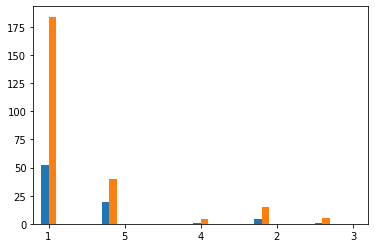

In [19]:
plt.hist(x1, width = -0.1)
plt.hist(x2, width = 0.1)

Часть 2. Подготовка кластеров к анализу

Наш датасет готов к кластеризации. Теперь на основе данных об уплате долгов можно составить два основных кластера, к которым мы будем относить людей. Первый кластер - люди, оплащивающие долги вовремя, для них значение столбца STATUS в исходном датасете - C. Второй кластер - люди, которые оплачивают долги с какой-либо задержкой. Также можно выделить различные группы в зависимости от длительности задержки во втором кластере, но для этого недостаточно данных, так как для каждого такого потенциального кластера количество наблюдений не превышает 200 при общем объеме наблюдений больше 20 тысяч.

In [13]:
merged.loc[merged['STATUS'] == 'C', 'Cluster'] = 1
merged.loc[merged['STATUS'] == '0', 'Cluster'] = 2
merged.loc[merged['STATUS'] == '1', 'Cluster'] = 2
merged.loc[merged['STATUS'] == '2', 'Cluster'] = 2
merged.loc[merged['STATUS'] == '3', 'Cluster'] = 2
merged.loc[merged['STATUS'] == '4', 'Cluster'] = 2
merged.loc[merged['STATUS'] == '5', 'Cluster'] = 2
merged = merged.drop('STATUS', 1)
merged

,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,Gender,Property,Working,University,Age_Days,Job_Days,Cluster
0,427500.0,2.0,1,1,1,1,12005,4542,1.0
1,427500.0,2.0,1,1,1,1,12005,4542,1.0
2,112500.0,2.0,1,1,1,0,21474,1134,1.0
3,270000.0,1.0,0,1,1,0,19110,3051,2.0
4,270000.0,1.0,0,1,1,0,19110,3051,1.0
...,...,...,...,...,...,...,...,...,...
20180,315000.0,2.0,1,1,1,0,17348,2420,2.0
20181,157500.0,2.0,0,1,1,1,12387,1325,1.0
20182,157500.0,2.0,0,1,0,1,12387,1325,1.0
20183,283500.0,2.0,0,1,1,0,17958,655,2.0


In [14]:
for i in np.unique(merged["Cluster"]): 
    print( "размер кластера ", int(i), sum(merged["Cluster"]==i))

размер кластера  1 12974
размер кластера  2 7211


Как можно заметить, размер первого кластера значительно превышает размер второго. Возьмем равное количество случайных наблюдений из каждого кластера, чтобы сбалансировать их. По 500 случайных наблюдений из каждого.

In [15]:
Data_1 = merged.loc[merged["Cluster"] == 1]
perm = np.random.permutation(Data_1.shape[0])
i1 = perm[:500]
Data_1 = Data_1.reset_index()
Data_1 = Data_1.drop('index', 1)
Data_1 = Data_1.loc[i1]
Data_1

,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,Gender,Property,Working,University,Age_Days,Job_Days,Cluster
11408,216000.0,2.0,0,0,1,1,17764,9574,1.0
10332,36900.0,2.0,1,1,1,0,18565,1800,1.0
7525,382500.0,1.0,1,1,1,0,11557,2412,1.0
4321,234000.0,3.0,1,1,1,0,11511,3611,1.0
3092,202500.0,1.0,0,1,1,1,22101,15038,1.0
...,...,...,...,...,...,...,...,...,...
8637,180000.0,3.0,0,1,1,1,17560,8923,1.0
8899,180000.0,2.0,1,1,1,0,21684,2422,1.0
3880,90000.0,1.0,0,0,1,1,21887,1526,1.0
8463,94500.0,1.0,0,1,0,1,22481,365243,1.0


In [16]:
Data_2 = merged.loc[merged["Cluster"] == 2]
perm = np.random.permutation(Data_2.shape[0])
i2 = perm[:500]
Data_2 = Data_2.reset_index()
Data_2 = Data_2.drop('index', 1)
Data_2 = Data_2.loc[i2]
Data_2

,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,Gender,Property,Working,University,Age_Days,Job_Days,Cluster
5292,135000.0,2.0,0,1,1,1,8961,923,2.0
4434,292500.0,3.0,1,1,1,0,12015,1550,2.0
1403,202500.0,2.0,0,1,1,1,21246,12163,2.0
7009,180000.0,2.0,0,1,1,0,13467,3850,2.0
1302,202500.0,2.0,1,1,1,0,18035,2026,2.0
...,...,...,...,...,...,...,...,...,...
2488,157500.0,3.0,0,0,1,1,13167,1641,2.0
5168,180000.0,2.0,0,1,1,0,18856,7130,2.0
3333,450000.0,2.0,1,1,1,1,19087,4434,2.0
2834,135000.0,3.0,0,0,1,1,11262,563,2.0


In [17]:
Data = pd.concat([Data_1, Data_2])
Data = Data.reset_index()
Data = Data.drop('index', 1)
Data

,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,Gender,Property,Working,University,Age_Days,Job_Days,Cluster
0,216000.0,2.0,0,0,1,1,17764,9574,1.0
1,36900.0,2.0,1,1,1,0,18565,1800,1.0
2,382500.0,1.0,1,1,1,0,11557,2412,1.0
3,234000.0,3.0,1,1,1,0,11511,3611,1.0
4,202500.0,1.0,0,1,1,1,22101,15038,1.0
...,...,...,...,...,...,...,...,...,...
995,157500.0,3.0,0,0,1,1,13167,1641,2.0
996,180000.0,2.0,0,1,1,0,18856,7130,2.0
997,450000.0,2.0,1,1,1,1,19087,4434,2.0
998,135000.0,3.0,0,0,1,1,11262,563,2.0


In [18]:
for i in np.unique(Data["Cluster"]): 
    print( "размер кластера ", int(i), sum(Data["Cluster"]==i))

размер кластера  1 500
размер кластера  2 500


Теперь наши кластеры более уравновешены. Необходимо подготовить данные к дальнейшему использованию.

In [19]:
Data_array = Data.loc[:, Data.columns != 'Cluster']
Data_array = np.asarray(Data_array)
Data_array

array([[2.1600e+05, 2.0000e+00, 0.0000e+00, ..., 1.0000e+00, 1.7764e+04,
        9.5740e+03],
       [3.6900e+04, 2.0000e+00, 1.0000e+00, ..., 0.0000e+00, 1.8565e+04,
        1.8000e+03],
       [3.8250e+05, 1.0000e+00, 1.0000e+00, ..., 0.0000e+00, 1.1557e+04,
        2.4120e+03],
       ...,
       [4.5000e+05, 2.0000e+00, 1.0000e+00, ..., 1.0000e+00, 1.9087e+04,
        4.4340e+03],
       [1.3500e+05, 3.0000e+00, 0.0000e+00, ..., 1.0000e+00, 1.1262e+04,
        5.6300e+02],
       [4.0500e+05, 2.0000e+00, 1.0000e+00, ..., 1.0000e+00, 1.0772e+04,
        5.4600e+02]])

In [20]:
Cluster_names = Data.loc[:, Data.columns.isin(['Cluster'])]
Cluster_names = Cluster_names.reset_index()
Cluster_names = Cluster_names.drop('index', 1)
Cluster_names

,Cluster
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
995,2.0
996,2.0
997,2.0
998,2.0


Часть 3. Различные способы кластеризации исходных данных.

Сначала воспользуем методом кластеризации K-means. 

In [21]:
scale = StandardScaler() # пронормируем данные
Data_array = scale.fit_transform(Data_array)

In [22]:
n_clusters=10
cost=[]
for i in range(1,n_clusters):
    kmean= KMeans(i)
    kmean.fit(Data_array)
    cost.append(kmean.inertia_)  

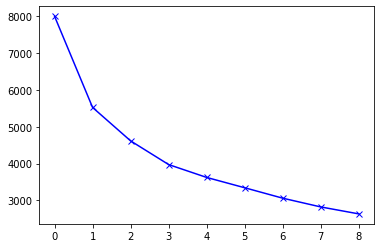

In [23]:
# Определим количество кластеров при помощи elbow метода
plt.plot(cost, 'bx-')

Согласно данному графику, необходимо разбивать генеральную совокупность на 3 кластера.

In [24]:
kmean= KMeans(3)
kmean.fit(Data_array)
labels=kmean.labels_

In [25]:
K_clusters = pd.concat([Data, pd.DataFrame({'K_cluster':labels})], axis=1)
K_clusters

,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,Gender,Property,Working,University,Age_Days,Job_Days,Cluster,K_cluster
0,216000.0,2.0,0,0,1,1,17764,9574,1.0,0
1,36900.0,2.0,1,1,1,0,18565,1800,1.0,1
2,382500.0,1.0,1,1,1,0,11557,2412,1.0,1
3,234000.0,3.0,1,1,1,0,11511,3611,1.0,1
4,202500.0,1.0,0,1,1,1,22101,15038,1.0,0
...,...,...,...,...,...,...,...,...,...,...
995,157500.0,3.0,0,0,1,1,13167,1641,2.0,0
996,180000.0,2.0,0,1,1,0,18856,7130,2.0,0
997,450000.0,2.0,1,1,1,1,19087,4434,2.0,1
998,135000.0,3.0,0,0,1,1,11262,563,2.0,0


In [26]:
New = K_clusters.loc[K_clusters["Cluster"] == 2]
New

,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,Gender,Property,Working,University,Age_Days,Job_Days,Cluster,K_cluster
500,135000.0,2.0,0,1,1,1,8961,923,2.0,0
501,292500.0,3.0,1,1,1,0,12015,1550,2.0,1
502,202500.0,2.0,0,1,1,1,21246,12163,2.0,0
503,180000.0,2.0,0,1,1,0,13467,3850,2.0,0
504,202500.0,2.0,1,1,1,0,18035,2026,2.0,1
...,...,...,...,...,...,...,...,...,...,...
995,157500.0,3.0,0,0,1,1,13167,1641,2.0,0
996,180000.0,2.0,0,1,1,0,18856,7130,2.0,0
997,450000.0,2.0,1,1,1,1,19087,4434,2.0,1
998,135000.0,3.0,0,0,1,1,11262,563,2.0,0


Посмотрим на характеристики каждого из трех кластеров.

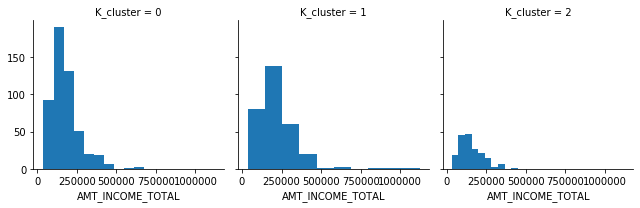

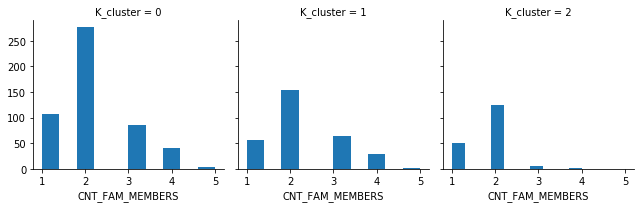

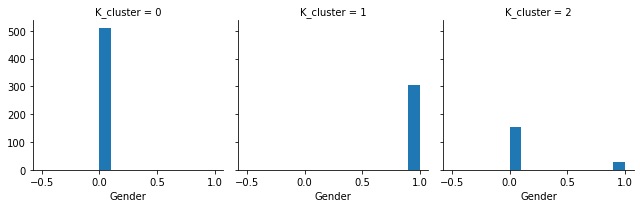

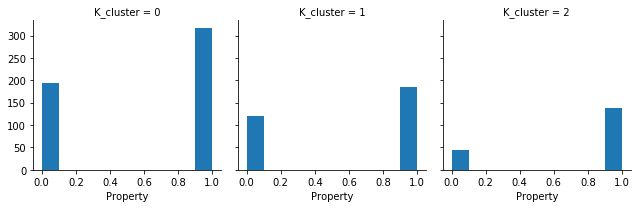

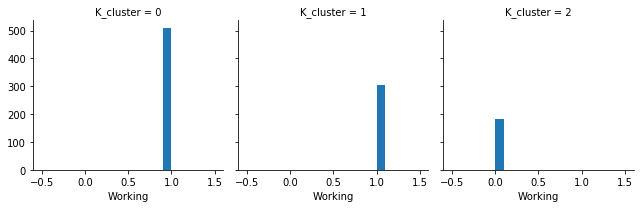

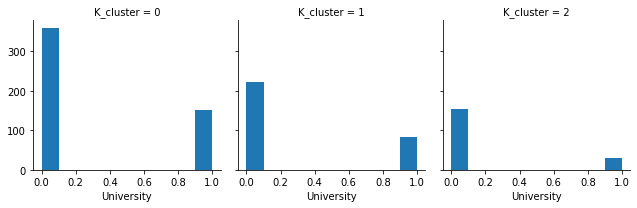

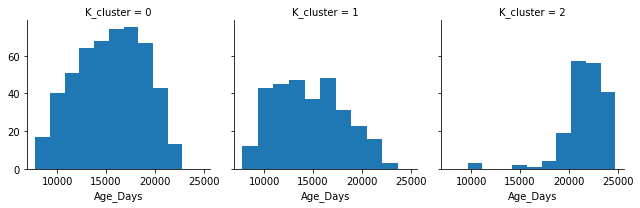

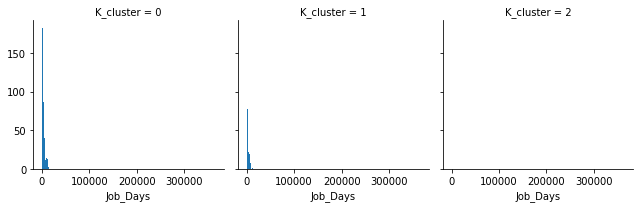

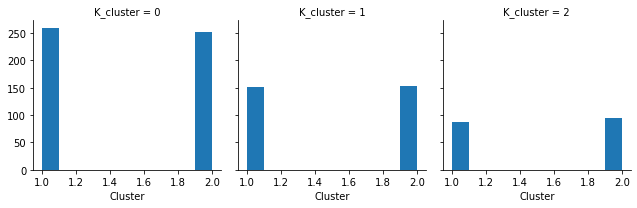

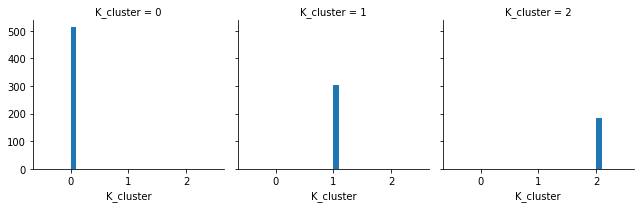

In [27]:
for c in K_clusters:
    grid= sns.FacetGrid(K_clusters, col='K_cluster')
    grid.map(plt.hist, c)

Как мы можем заметить, разбиение на кластеры Kmeans не позволило нам с уверенностью предсказать, к какому кластеру фактически относится человек.Теперь воспользуемся методом PCA для визуализации полученных нами кластеров.

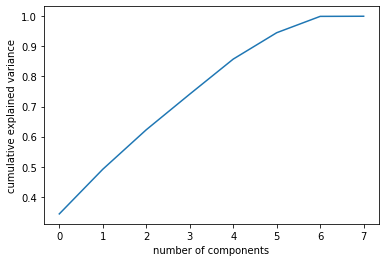

In [28]:
pca = PCA().fit(Data_array.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Будем использовать для снижения размерности 4 главных компоненты, так как они объясняют 80% вариации исходных данных

In [29]:
pca = PCA(n_components=4, svd_solver='full')
Data_Graph = pca.fit_transform(Data_array)
Data_Graph = np.concatenate((Data_Graph, Cluster_names), axis=1)
column_names = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'Cluster']
Data_Graph = pd.DataFrame(Data_Graph, columns=column_names)
Data_Graph

,PCA1,PCA2,PCA3,PCA4,Cluster
0,-0.616070,0.411560,2.101472,0.105187,1.0
1,-0.114481,-0.665785,-1.454457,-0.460230,1.0
2,-1.197951,1.635913,-1.140954,-1.497694,1.0
3,-1.474531,0.306351,-1.714347,0.669338,1.0
4,0.454527,0.988828,1.049571,-1.417395,1.0
...,...,...,...,...,...
995,-1.338390,-0.326912,1.856650,1.303372,2.0
996,0.141621,-0.489799,-0.527841,-0.759969,2.0
997,-0.990820,3.307900,-0.214487,-0.259150,2.0
998,-1.526893,-0.559917,1.879458,1.374484,2.0


Text(0.5, 1.0, 'PCA of Credit dataset')

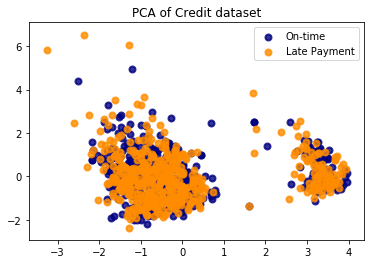

In [30]:
colors = ['navy', 'darkorange']
target_names = ['On-time','Late Payment']
lw = 2

for color, i, target_name in zip(colors, [1, 2], target_names):
    Data_Graph_1 = Data_Graph.loc[Data_Graph['Cluster'] == i]
    plt.scatter(Data_Graph_1.iloc[:,0], Data_Graph_1.iloc[:,1], color=color, alpha=.8, lw=lw,
                label=target_names[i-1])
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Credit dataset')

Text(0.5, 1.0, 'PCA of Credit dataset')

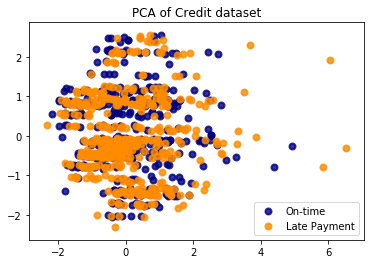

In [31]:
for color, i, target_name in zip(colors, [1, 2], target_names):
    Data_Graph_1 = Data_Graph.loc[Data_Graph['Cluster'] == i]
    plt.scatter(Data_Graph_1.iloc[:,1], Data_Graph_1.iloc[:,2], color=color, alpha=.8, lw=lw,
                label=target_names[i-1])
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Credit dataset')

Различные двумерные графики не дают возможность разделить наши наблюдения на две группы, попробуем построить график в 3D

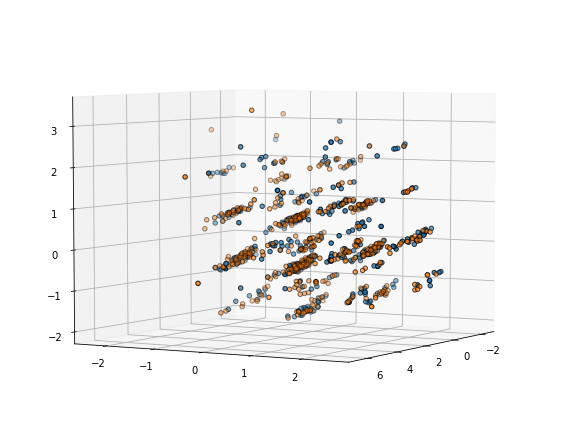

In [32]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=5, azim=30)
for color, i, target_name in zip(colors, [1, 2], target_names):
    Data_Graph_1 = Data_Graph.loc[Data_Graph['Cluster'] == i]
    ax.scatter(Data_Graph_1.iloc[:,1], Data_Graph_1.iloc[:,2], Data_Graph_1.iloc[:,3], cmap=plt.cm.spring, edgecolor='k')

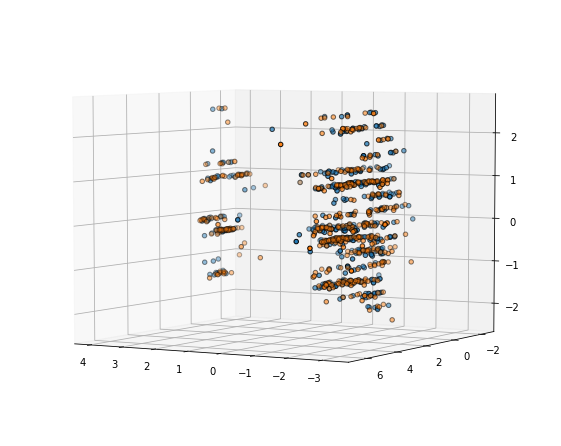

In [33]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=5, azim=120)
for color, i, target_name in zip(colors, [1, 2], target_names):
    Data_Graph_1 = Data_Graph.loc[Data_Graph['Cluster'] == i]
    ax.scatter(Data_Graph_1.iloc[:,0], Data_Graph_1.iloc[:,1], Data_Graph_1.iloc[:,2], cmap=plt.cm.spring, edgecolor='k')

Данные невозможно разделить на две группы визуальным методом PCA.

Часть 4. Различные способы кластеризации и их результативность на тестовой и тренировочной выборке. Применяем следующие методы: 1) Метод опорных векторов, 2) Гребневый классификатор, 3) Многослойный перцептрон, 4) Стохастический градиенный спуск, 5) Случайный лес, 6) Дерево решений и 7) Метод ближайшего соседа

In [34]:
Cluster_names = np.asarray(Cluster_names)
Cluster_names = np.ravel(Cluster_names)

Возьмем 80% от датасета как тренировочные данные, оценивать точность классификации будем на оставшихся 20%

In [35]:
def train( clf, data, labels ):
    n = data.shape[0]
    perm = np.random.permutation( n )
    tr_n = int(0.8 * n)
    train = perm[ :tr_n ]
    valid = perm[ tr_n: ]

    train_dig = data[ train ]
    train_lab = labels[ train ]

    valid_dig = data[ valid ]
    valid_lab = labels[ valid ]

    clf.fit( train_dig, train_lab )

    val_cnt = sum( clf.predict( valid_dig ) == valid_lab ) 
    return clf.predict( valid_dig ), valid_lab

Ниже приведены результаты для различных способов кластеризации данных

In [36]:
clf = linear_model.RidgeClassifier()
pred, valid = train( clf, Data_array, Cluster_names)
qq = pred == valid
sum(qq)/qq.shape[0]

0.54

In [37]:
clf = svm.SVC( gamma = 0.001 )
pred, valid = train( clf, Data_array, Cluster_names)
qq = pred == valid
sum(qq)/qq.shape[0]

0.495

In [38]:
clf = neural_network.MLPClassifier( )
pred, valid = train( clf, Data_array, Cluster_names)
qq = pred == valid
sum(qq)/qq.shape[0]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.525

In [39]:
clf = linear_model.SGDClassifier()
pred, valid = train( clf, Data_array, Cluster_names)
qq = pred == valid
sum(qq)/qq.shape[0]

0.47

In [40]:
clf = DecisionTreeClassifier(random_state = 42)
pred, valid = train( clf, Data_array, Cluster_names)
qq = pred == valid
sum(qq)/qq.shape[0]

0.52

In [41]:
clf = DecisionTreeClassifier(criterion = "entropy", max_depth=10, min_impurity_decrease=0.5 )
pred, valid = train( clf, Data_array, Cluster_names)
qq = pred == valid
sum(qq)/qq.shape[0]

0.485

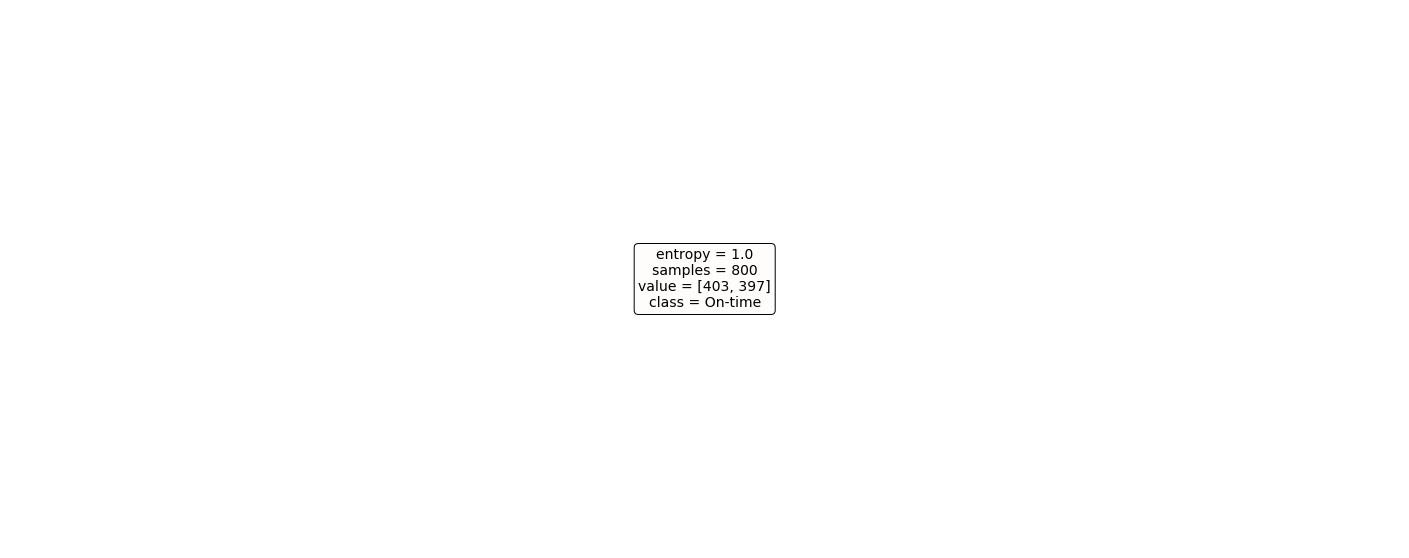

In [42]:
plt.figure(figsize=(25,10))
a = plot_tree(clf, 
              feature_names=Data.columns.values[:-1], 
              class_names=['On-time','Late Payment'], 
              filled=True, 
              rounded=True, 
              fontsize=14)

Как можно заметить, не один из способов кластеризации не дает сколько-нибудь удовлетворительных результатов. Точность предсказиний - 50%, что практически идентично случайным предсказаниям. Попробуем оценить логистическую регрессию с похожими параметрами.

In [43]:
clf = linear_model.LogisticRegression()
pred, valid = train( clf, Data_array, Cluster_names)
qq = pred == valid
sum(qq)/qq.shape[0]

0.48

In [44]:
logistic = LogisticRegression()
logistic.fit(Data_array, Cluster_names)
logistic.score(Data_array, Cluster_names)
print('Coefficient: \n', logistic.coef_)
print('Intercept: \n', logistic.intercept_)
print('R² Value: \n', logistic.score(Data_array, Cluster_names))

Coefficient: 
 [[ 0.12798531 -0.09317288 -0.02437476  0.00697448  0.16886775 -0.12269154
  -0.14749945  0.27618564]]
Intercept: 
 [0.0001301]
R² Value: 
 0.537


Как можно заметить, объясняющая сила данной модели достаточно низкая. Приходим к выводу, что кластеризировать такие данные нельзя